In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from kneebow.rotor import Rotor
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.gridspec as gridspec
import seaborn as sns



In [4]:
dataset_0 = pd.read_csv("Datos/Transformados/logs.csv")
dataset_0


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
57165,51710,43069,65147,43069,allow,70,70,0,2,8,2,0
57166,63691,80,13237,80,allow,314,192,122,6,15,4,2
57167,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
57168,54871,445,0,0,drop,70,70,0,1,0,1,0


In [5]:
dummies = pd.get_dummies(dataset_0.Action, dtype=int,drop_first=True)
df = pd.concat([
    dataset_0.drop("Action", axis=1),
    dummies
], axis = 1)
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,deny,drop,reset-both
0,57222,53,54587,53,177,94,83,2,30,1,1,0,0,0
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,0,0,0
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,0,0,0
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,0,0,0
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,0,0,0


In [6]:
dataset = df.drop(["Source Port","Destination Port","NAT Source Port","NAT Destination Port"], axis=1)
dataset

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,deny,drop,reset-both
0,177,94,83,2,30,1,1,0,0,0
1,4768,1600,3168,19,17,10,9,0,0,0
2,238,118,120,2,1199,1,1,0,0,0
3,3327,1438,1889,15,17,8,7,0,0,0
4,25358,6778,18580,31,16,13,18,0,0,0
...,...,...,...,...,...,...,...,...,...,...
57165,70,70,0,2,8,2,0,0,0,0
57166,314,192,122,6,15,4,2,0,0,0
57167,4680740,67312,4613428,4675,77,985,3690,0,0,0
57168,70,70,0,1,0,1,0,0,1,0


In [7]:
dataset.columns

Index(['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets',
       'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'deny', 'drop',
       'reset-both'],
      dtype='object')

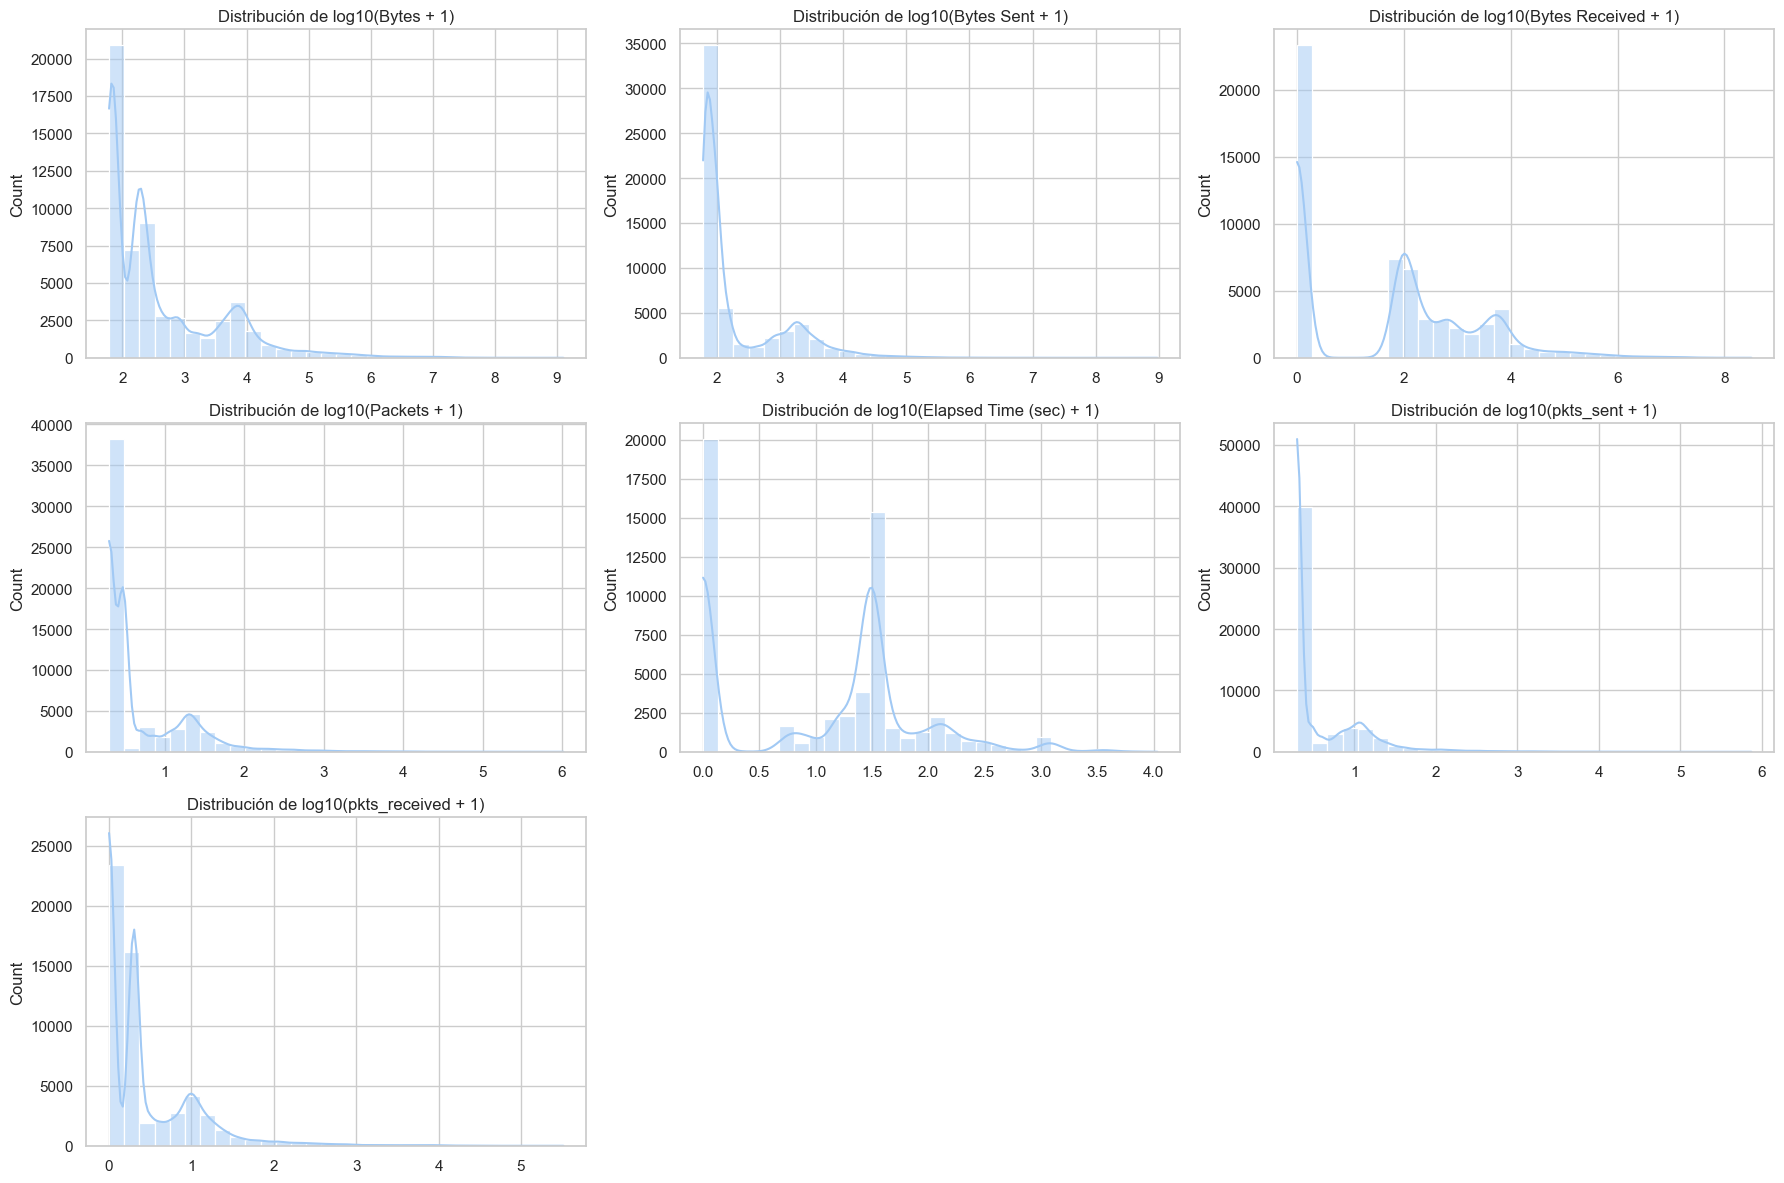

In [8]:
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.dpi'] = 100

numeric_vars = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 
                'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']

plt.figure(figsize=(18, 12))
for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 3, i)
    min_val = df[var].min()
    max_val = df[var].max()
    
    if min_val == 0:
        range_ratio = max_val / (min_val + 1) 
    else:
        range_ratio = max_val / min_val
    
    if range_ratio > 100 and min_val >= 0:
        log_data = np.log10(df[var] + 1)
        sns.histplot(log_data, kde=True, bins=30)
        plt.title(f'Distribución de log10({var} + 1)')
    else:
        sns.histplot(df[var], kde=True, bins=30)
        plt.title(f'Distribución de {var}')
    
    plt.xlabel('')
plt.tight_layout()
plt.show()


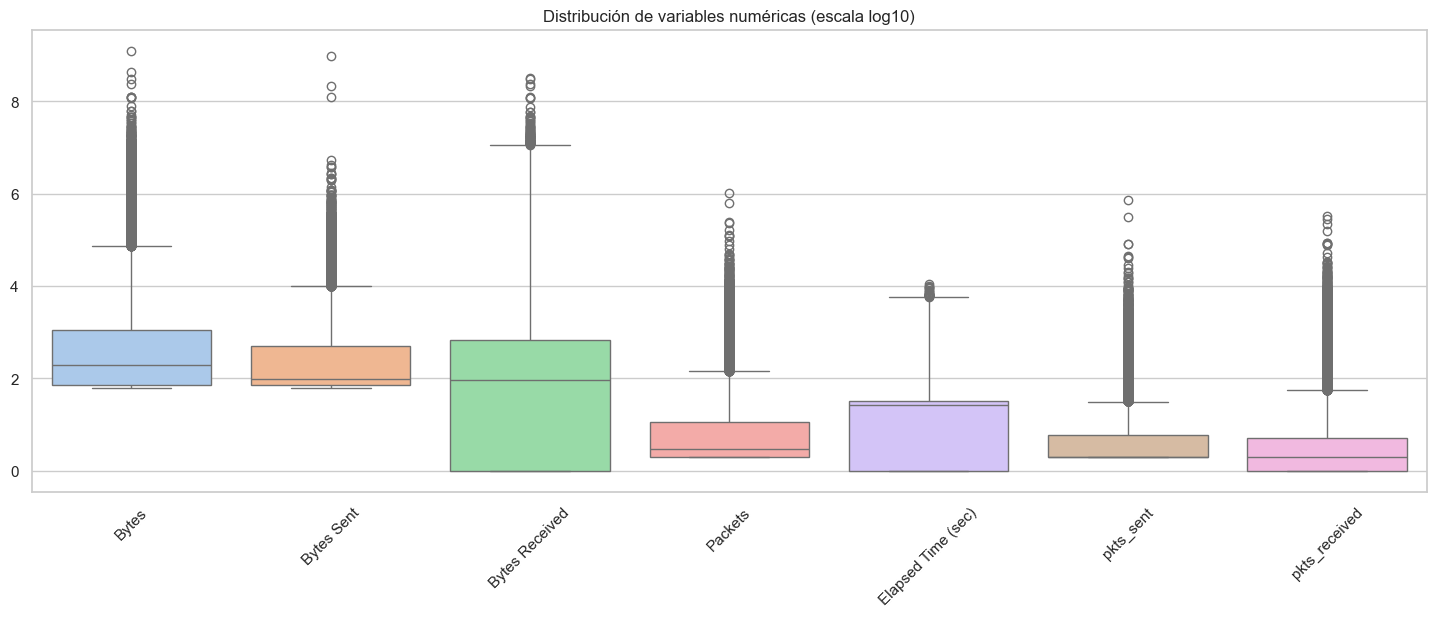

In [9]:
plt.figure(figsize=(18, 6))
log_transformed = df[numeric_vars].apply(lambda x: np.log10(x + 1))
sns.boxplot(data=log_transformed, whis=1.5)
plt.xticks(rotation=45)
plt.title('Distribución de variables numéricas (escala log10)')
plt.show()

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset)

In [26]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

fig = px.scatter(
    df_pca,
    x="PC1",
    y="PC2",
    title="PCA con 2 Componentes",
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Épsilon óptimo: 0.575804393061436
min_samples: 8, clusters: 6, silhouette_score: 0.9022
min_samples: 9, clusters: 5, silhouette_score: 0.9023
min_samples: 10, clusters: 5, silhouette_score: 0.9023
min_samples: 11, clusters: 7, silhouette_score: 0.8989
min_samples: 12, clusters: 8, silhouette_score: 0.9003
min_samples: 13, clusters: 7, silhouette_score: 0.9008
min_samples: 14, clusters: 7, silhouette_score: 0.9007
min_samples: 15, clusters: 9, silhouette_score: 0.9010
min_samples: 16, clusters: 9, silhouette_score: 0.9011
min_samples: 17, clusters: 9, silhouette_score: 0.9012
min_samples: 18, clusters: 8, silhouette_score: 0.9014
min_samples: 19, clusters: 7, silhouette_score: 0.9021

Mejores parámetros -> eps: 0.575804393061436, min_samples: 9, silhouette_score: 0.9023


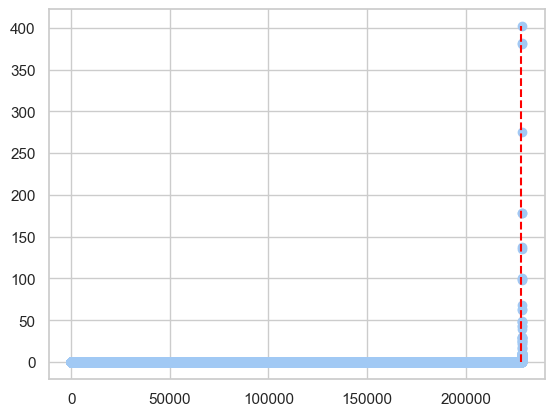

In [27]:
def calculate_kn_distance(X, neigh=2):
    neigh = NearestNeighbors(n_neighbors=neigh)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    return distances[:, 1:].reshape(-1)

def get_eps(X, neigh=2):
    eps_dist = np.sort(calculate_kn_distance(X, neigh=neigh))
    rotor = Rotor()
    curve_xy = np.concatenate([np.arange(eps_dist.shape[0]).reshape(-1, 1), eps_dist.reshape(-1, 1)], axis=1)
    rotor.fit_rotate(curve_xy)
    rotor.plot_elbow()  
    e_idx = rotor.get_elbow_index()
    return curve_xy[e_idx, 1]

optimal_eps = get_eps(X_scaled, neigh=5)
print(f"Épsilon óptimo: {optimal_eps}")

best_score = -1
best_params = (None, None)
for min_samples in range(8, 20):
    db = DBSCAN(eps=optimal_eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        score = silhouette_score(X_scaled, labels)
        print(f"min_samples: {min_samples}, clusters: {n_clusters}, silhouette_score: {score:.4f}")
        if score > best_score:
            best_score = score
            best_params = (optimal_eps, min_samples)

print(f"\nMejores parámetros -> eps: {best_params[0]}, min_samples: {best_params[1]}, silhouette_score: {best_score:.4f}")


In [28]:
epsilon=0.575804393061436
min_samples=9

In [29]:
db = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = db.fit_predict(X_scaled)

In [30]:
dataset_0["cluster"] = labels
anomalies = dataset_0[dataset_0["cluster"] ==-1]
print(f"Total de anomalías detectadas: {len(anomalies)}")


Total de anomalías detectadas: 122


In [31]:
dataset_0["cluster"].value_counts()

cluster
 0    37131
 1    11635
 2     8042
 4      186
-1      122
 3       54
Name: count, dtype: int64

In [32]:
print("Cluster -1")
display(dataset_0[dataset_0["cluster"] == -1].describe()),print("Cluster 0")
display(dataset_0[dataset_0["cluster"] == -0].describe())
print("Cluster 1")
display(dataset_0[dataset_0["cluster"] == 1].describe())
print("Cluster 2")
display(dataset_0[dataset_0["cluster"] == 2].describe())


Cluster -1


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,cluster
count,122.000000,122.000000,122.000000,122.000000,1.220000e+02,1.220000e+02,1.220000e+02,1.220000e+02,122.000000,122.000000,122.000000,122.0
mean,49865.114754,4996.467213,34450.622951,4996.467213,3.407827e+07,1.108986e+07,2.298841e+07,3.453259e+04,2554.139344,14935.852459,19596.737705,-1.0
std,11535.645427,13081.406264,18914.200805,13081.406264,1.257785e+08,8.839005e+07,5.148422e+07,1.139149e+05,2924.653889,73342.854831,47340.931414,0.0
min,8430.000000,53.000000,1716.000000,53.000000,2.268000e+03,1.050000e+03,0.000000e+00,1.500000e+01,37.000000,8.000000,0.000000,-1.0
25%,44632.750000,443.000000,19516.250000,443.000000,2.475775e+04,7.531500e+03,9.153500e+03,1.037500e+02,225.000000,71.250000,45.250000,-1.0
50%,52897.000000,443.000000,34424.500000,443.000000,6.853134e+06,2.473870e+05,5.705770e+06,1.001300e+04,626.000000,2560.000000,5560.500000,-1.0
75%,57323.000000,2652.500000,50670.250000,2652.500000,2.282625e+07,6.554565e+05,2.144988e+07,2.443225e+04,5257.000000,7477.500000,16582.500000,-1.0
max,65356.000000,63666.000000,65509.000000,63666.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000,-1.0


Cluster 0


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,cluster
count,37131.000000,37131.000000,37131.000000,37131.000000,3.713100e+04,3.713100e+04,3.713100e+04,37131.000000,37131.000000,37131.000000,37131.000000,37131.0
mean,51344.781611,4656.501737,33653.785355,4585.724570,5.932821e+04,2.988855e+03,5.633936e+04,67.009318,89.250330,23.069295,43.940023,0.0
std,11875.165425,12496.636818,18916.200146,12406.914518,5.954736e+05,1.861178e+04,5.837318e+05,555.546362,215.227203,161.729700,404.507131,0.0
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000,0.000000,1.000000,0.000000,0.0
25%,49419.500000,53.000000,17239.500000,53.000000,1.930000e+02,9.400000e+01,9.100000e+01,2.000000,27.000000,1.000000,1.000000,0.0
50%,53797.000000,80.000000,34084.000000,80.000000,4.140000e+02,1.200000e+02,2.180000e+02,3.000000,30.000000,2.000000,1.000000,0.0
75%,57379.500000,443.000000,50368.000000,443.000000,5.102000e+03,1.556000e+03,3.006000e+03,19.000000,47.000000,10.000000,9.000000,0.0
max,65534.000000,65535.000000,65535.000000,65535.000000,1.487707e+07,1.123031e+06,1.469762e+07,13837.000000,2615.000000,5536.000000,9919.000000,0.0


Cluster 1


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,cluster
count,11635.000000,11635.0,11635.0,11635.0,11635.000000,11635.000000,11635.0,11635.0,11635.0,11635.0,11635.0,11635.0
mean,57131.494284,445.0,0.0,0.0,68.556768,68.556768,0.0,1.0,0.0,1.0,0.0,1.0
std,4771.922820,0.0,0.0,0.0,1.921022,1.921022,0.0,0.0,0.0,0.0,0.0,0.0
min,49156.000000,445.0,0.0,0.0,66.000000,66.000000,0.0,1.0,0.0,1.0,0.0,1.0
25%,52940.500000,445.0,0.0,0.0,66.000000,66.000000,0.0,1.0,0.0,1.0,0.0,1.0
50%,57012.000000,445.0,0.0,0.0,70.000000,70.000000,0.0,1.0,0.0,1.0,0.0,1.0
75%,61279.500000,445.0,0.0,0.0,70.000000,70.000000,0.0,1.0,0.0,1.0,0.0,1.0
max,65533.000000,445.0,0.0,0.0,70.000000,70.000000,0.0,1.0,0.0,1.0,0.0,1.0


Cluster 2


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,cluster
count,8042.000000,8042.000000,8042.000000,8042.000000,8042.000000,8042.000000,8042.000000,8042.00000,8042.000000,8042.000000,8042.000000,8042.0
mean,37579.505098,34401.997016,59.314723,4.033076,91.144864,90.817583,0.327282,1.00373,0.000249,1.001741,0.001990,2.0
std,20970.375754,19134.160479,1732.467110,181.124917,100.738638,98.690321,16.628656,0.10335,0.015769,0.047281,0.063053,0.0
min,0.000000,0.000000,0.000000,0.000000,60.000000,60.000000,0.000000,1.00000,0.000000,1.000000,0.000000,2.0
25%,17838.250000,22114.000000,0.000000,0.000000,62.000000,62.000000,0.000000,1.00000,0.000000,1.000000,0.000000,2.0
50%,44246.500000,35440.000000,0.000000,0.000000,66.000000,66.000000,0.000000,1.00000,0.000000,1.000000,0.000000,2.0
75%,55921.000000,50584.000000,0.000000,0.000000,72.000000,72.000000,0.000000,1.00000,0.000000,1.000000,0.000000,2.0
max,65529.000000,65504.000000,62347.000000,8889.000000,1850.000000,1514.000000,1419.000000,5.00000,1.000000,3.000000,2.000000,2.0


In [33]:
print("Cluster -1")
display(dataset_0[dataset_0["cluster"] == -1]),print("Cluster 0")
display(dataset_0[dataset_0["cluster"] == -0])
print("Cluster 1")
display(dataset_0[dataset_0["cluster"] == 1])
print("Cluster 2")
display(dataset_0[dataset_0["cluster"] == 2])


Cluster -1


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,cluster
50,63842,45682,31353,45682,allow,4687209,3850148,837061,4974,107,3004,1970,-1
516,44323,5228,8392,5228,allow,7292,4509,2783,50,6392,25,25,-1
1250,43199,5228,42030,5228,allow,10588,2455,8133,46,5724,19,27,-1
1625,44246,5228,57956,5228,allow,19678,4762,14916,98,9851,54,44,-1
1664,49126,443,33194,443,allow,3800867,77753,3723114,3263,625,478,2785,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55618,50121,443,24047,443,allow,307104860,2750998,304353862,234597,6122,15017,219580,-1
55779,54525,80,24122,80,allow,50436663,1205750,49230913,49415,198,16827,32588,-1
56356,59570,443,54074,443,allow,6713,3052,3661,49,5974,15,34,-1
56666,30188,36914,20864,36914,allow,2668,1950,718,16,7827,14,2,-1


Cluster 0


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,cluster
0,57222,53,54587,53,allow,177,94,83,2,30,1,1,0
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9,0
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1,0
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7,0
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57156,56985,53,45052,53,allow,711,87,624,2,31,1,1,0
57164,65323,53,33275,53,allow,356,118,238,2,30,1,1,0
57165,51710,43069,65147,43069,allow,70,70,0,2,8,2,0,0
57166,63691,80,13237,80,allow,314,192,122,6,15,4,2,0


Cluster 1


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,cluster
141,51048,445,0,0,drop,70,70,0,1,0,1,0,1
142,51045,445,0,0,drop,70,70,0,1,0,1,0,1
145,55725,445,0,0,drop,70,70,0,1,0,1,0,1
146,55723,445,0,0,drop,70,70,0,1,0,1,0,1
147,55724,445,0,0,drop,70,70,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57158,50270,445,0,0,drop,66,66,0,1,0,1,0,1
57159,50268,445,0,0,drop,66,66,0,1,0,1,0,1
57161,49783,445,0,0,drop,70,70,0,1,0,1,0,1
57168,54871,445,0,0,drop,70,70,0,1,0,1,0,1


Cluster 2


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,cluster
143,13394,23,0,0,deny,60,60,0,1,0,1,0,2
144,61078,57470,0,0,deny,62,62,0,1,0,1,0,2
156,62776,62413,0,0,deny,146,146,0,1,0,1,0,2
158,46448,30170,0,0,deny,159,159,0,1,0,1,0,2
159,10688,25174,0,0,deny,146,146,0,1,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57108,40078,44847,0,0,deny,62,62,0,1,0,1,0,2
57110,51098,60043,0,0,deny,62,62,0,1,0,1,0,2
57160,54013,37965,0,0,deny,66,66,0,1,0,1,0,2
57162,55142,26467,0,0,deny,66,66,0,1,0,1,0,2


In [34]:
dataset_0[dataset_0["cluster"] == -1]

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,cluster
50,63842,45682,31353,45682,allow,4687209,3850148,837061,4974,107,3004,1970,-1
516,44323,5228,8392,5228,allow,7292,4509,2783,50,6392,25,25,-1
1250,43199,5228,42030,5228,allow,10588,2455,8133,46,5724,19,27,-1
1625,44246,5228,57956,5228,allow,19678,4762,14916,98,9851,54,44,-1
1664,49126,443,33194,443,allow,3800867,77753,3723114,3263,625,478,2785,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55618,50121,443,24047,443,allow,307104860,2750998,304353862,234597,6122,15017,219580,-1
55779,54525,80,24122,80,allow,50436663,1205750,49230913,49415,198,16827,32588,-1
56356,59570,443,54074,443,allow,6713,3052,3661,49,5974,15,34,-1
56666,30188,36914,20864,36914,allow,2668,1950,718,16,7827,14,2,-1


In [35]:
dataset_0[dataset_0["cluster"] == 0]

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,cluster
0,57222,53,54587,53,allow,177,94,83,2,30,1,1,0
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9,0
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1,0
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7,0
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57156,56985,53,45052,53,allow,711,87,624,2,31,1,1,0
57164,65323,53,33275,53,allow,356,118,238,2,30,1,1,0
57165,51710,43069,65147,43069,allow,70,70,0,2,8,2,0,0
57166,63691,80,13237,80,allow,314,192,122,6,15,4,2,0


In [36]:
dataset_0[dataset_0["cluster"] == 1]

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,cluster
141,51048,445,0,0,drop,70,70,0,1,0,1,0,1
142,51045,445,0,0,drop,70,70,0,1,0,1,0,1
145,55725,445,0,0,drop,70,70,0,1,0,1,0,1
146,55723,445,0,0,drop,70,70,0,1,0,1,0,1
147,55724,445,0,0,drop,70,70,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57158,50270,445,0,0,drop,66,66,0,1,0,1,0,1
57159,50268,445,0,0,drop,66,66,0,1,0,1,0,1
57161,49783,445,0,0,drop,70,70,0,1,0,1,0,1
57168,54871,445,0,0,drop,70,70,0,1,0,1,0,1


In [37]:
dataset_0[dataset_0["cluster"] == 2]

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,cluster
143,13394,23,0,0,deny,60,60,0,1,0,1,0,2
144,61078,57470,0,0,deny,62,62,0,1,0,1,0,2
156,62776,62413,0,0,deny,146,146,0,1,0,1,0,2
158,46448,30170,0,0,deny,159,159,0,1,0,1,0,2
159,10688,25174,0,0,deny,146,146,0,1,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57108,40078,44847,0,0,deny,62,62,0,1,0,1,0,2
57110,51098,60043,0,0,deny,62,62,0,1,0,1,0,2
57160,54013,37965,0,0,deny,66,66,0,1,0,1,0,2
57162,55142,26467,0,0,deny,66,66,0,1,0,1,0,2


In [38]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["cluster"] = labels

df_pca["cluster_label"] = df_pca["cluster"].apply(lambda x: "Anomalía" if x == -1 else f"Cluster {x}")

fig = px.scatter(
    df_pca,
    x="PC1",
    y="PC2",
    color="cluster_label",
    title="Visualización de Clústeres DBSCAN con PCA (Plotly)",
    labels={"cluster_label": "Grupo"},
    hover_data=["cluster"]
)

fig.update_layout(legend_title="Clústeres / Anomalías")
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

DECIDIR QUE CLUSTERS SON ANOMALOS

In [39]:
dataset_0["cluster"].value_counts()

cluster
 0    37131
 1    11635
 2     8042
 4      186
-1      122
 3       54
Name: count, dtype: int64

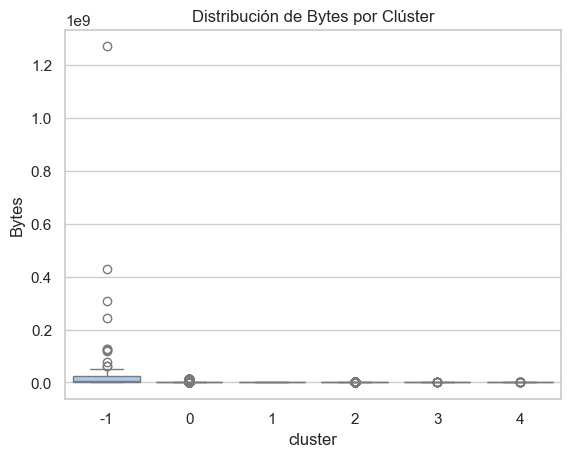

In [40]:
sns.boxplot(x="cluster", y="Bytes", data=dataset_0)
plt.title("Distribución de Bytes por Clúster")
plt.show()


In [41]:
grouped = dataset_0.groupby("cluster")
variances = grouped[numeric_vars].var()
print(variances)


                Bytes    Bytes Sent  Bytes Received       Packets  \
cluster                                                             
-1       1.582022e+16  7.812802e+15    2.650625e+15  1.297662e+10   
 0       3.545889e+11  3.463984e+08    3.407429e+11  3.086318e+05   
 1       3.690326e+00  3.690326e+00    0.000000e+00  0.000000e+00   
 2       1.014827e+04  9.739780e+03    2.765122e+02  1.068127e-02   
 3       6.613591e+03  3.176694e+03    8.628931e+02  1.584906e+00   
 4       9.340297e+08  2.859652e+08    3.635319e+08  1.709646e+04   

         Elapsed Time (sec)     pkts_sent  pkts_received  
cluster                                                   
-1             8.553600e+06  5.379174e+09   2.241164e+09  
 0             4.632275e+04  2.615650e+04   1.636260e+05  
 1             0.000000e+00  0.000000e+00   0.000000e+00  
 2             2.486634e-04  2.235497e-03   3.975646e-03  
 3             1.149546e-01  7.044025e-01   1.761006e-01  
 4             9.457760e+04  3.999

In [42]:
print(dataset_0["cluster"].value_counts())


cluster
 0    37131
 1    11635
 2     8042
 4      186
-1      122
 3       54
Name: count, dtype: int64


In [43]:
means = grouped[numeric_vars].mean()
print(means)


                Bytes    Bytes Sent  Bytes Received       Packets  \
cluster                                                             
-1       3.407827e+07  1.108986e+07    2.298841e+07  34532.590164   
 0       5.932821e+04  2.988855e+03    5.633936e+04     67.009318   
 1       6.855677e+01  6.855677e+01    0.000000e+00      1.000000   
 2       9.114486e+01  9.081758e+01    3.272818e-01      1.003730   
 3       1.573519e+02  1.417963e+02    1.555556e+01      1.666667   
 4       9.975280e+03  4.094715e+03    5.880565e+03     45.064516   

         Elapsed Time (sec)     pkts_sent  pkts_received  
cluster                                                   
-1              2554.139344  14935.852459   19596.737705  
 0                89.250330     23.069295      43.940023  
 1                 0.000000      1.000000       0.000000  
 2                 0.000249      1.001741       0.001990  
 3                 0.129630      1.444444       0.222222  
 4              3595.940860     23

In [44]:
#tomamos como anomalos cluster -1, 4. Explicacion en el informe
datos_limpios = dataset_0[dataset_0["cluster"].isin([0,1,2,3])]
anomalias = dataset_0[dataset_0["cluster"].isin([-1,4])]


In [45]:
datos_limpios.shape,anomalias.shape

((56862, 13), (308, 13))

In [46]:
datos_limpios.to_csv("Datos/Transformados/logs_sin_anomalias.csv", index=False)
